In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
import random
import os
import cv2

!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
# from keras.layers.merge import concatenate
from tensorflow.keras.models import Model
from keras.preprocessing import image
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imutils import paths
import argparse

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_url = 'https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database?recency=last7Days'
data_dir = '/content/COVID-19_Radiography_Dataset'

In [ ]:
# #load training and testing dataset from output directory where the split is fixed for all models
# train_datagen=ImageDataGenerator(rescale = 1./255,
#                                    rotation_range=15,
#                                    fill_mode="nearest",
#                                    horizontal_flip = True)
# valid_datagen=ImageDataGenerator(rescale = 1./255)
# test_datagen=ImageDataGenerator(rescale = 1./255)

# training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/train',
#                                                  target_size = (224, 224),
#                                                  batch_size = 64,
#                                                  class_mode = 'categorical',
#                                                  shuffle=True)
# valid_set=valid_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/val',
#                                             target_size = (224, 224),
#                                             batch_size = 64,
#                                             class_mode = 'categorical',
#                                             shuffle = False)
# test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/New_DS/output/test',
#                                             target_size = (224, 224),
#                                             batch_size = 64,
#                                             class_mode = 'categorical',
#                                             shuffle = False)

In [8]:
!pip install split-folders
import splitfolders
input_folder = '/content/drive/MyDrive/Covid_DS/Covid19_Radiography Dataset'
splitfolders.ratio( input_folder,
                   output="output",seed=1337,ratio=(0.7,0.2,0.1)) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 17606 files [01:21, 215.03 files/s]


In [9]:
#load training and testing dataset from directory
train_datagen=ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   fill_mode="nearest",
                                   horizontal_flip = True)
valid_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

training_set=train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical',
                                                 shuffle=True)
valid_set=valid_datagen.flow_from_directory('/content/output/val',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)
test_set=test_datagen.flow_from_directory('/content/output/test',
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical',
                                            shuffle = False)

Found 12323 images belonging to 4 classes.
Found 3520 images belonging to 4 classes.
Found 1763 images belonging to 4 classes.


In [10]:
print(training_set.class_indices)
print(valid_set.class_indices)
print(test_set.class_indices)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


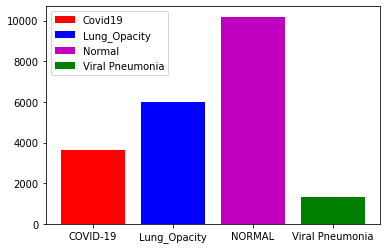

In [11]:
#visulaize data
fig, ax = plt.subplots()
ax.bar("COVID-19",3616,color="r",label="Covid19")
ax.bar("Lung_Opacity",6012 ,color="b",label="Lung_Opacity")
ax.bar("NORMAL",10192,color="m",label="Normal")
ax.bar("Viral Pneumonia",1345,color="g",label="Viral Pneumonia")
ax.legend()

In [12]:
#tf.keras.applications.ResNet50
from tensorflow.keras.layers import BatchNormalization
ResNet50_MODEL = Sequential()
ResNet50_MODEL.add(tf.keras.applications.ResNet50(include_top=False, pooling='avg', weights="imagenet"))
ResNet50_MODEL.add(Flatten())
ResNet50_MODEL.add(BatchNormalization())
ResNet50_MODEL.add(Dense(2048, activation='relu'))
ResNet50_MODEL.add(BatchNormalization())
ResNet50_MODEL.add(Dense(1024, activation='relu'))
ResNet50_MODEL.add(BatchNormalization())
ResNet50_MODEL.add(Dense(4, activation='softmax'))

ResNet50_MODEL.layers[0].trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [13]:
ResNet50_MODEL.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 1024)              2

In [14]:
tf.keras.callbacks.ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler

In [15]:
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [16]:
epochs = 100
learning_rate = 0.001
decay_rate = learning_rate / epochs
optimizer_details = Adam(lr = learning_rate, decay = decay_rate)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [17]:
ResNet50_MODEL.compile(optimizer = optimizer_details, 
              loss='categorical_crossentropy',
              metrics=['accuracy','Precision','Recall'])
history = ResNet50_MODEL.fit(training_set, validation_data = valid_set, epochs=epochs, verbose=1, callbacks=[early])

Epoch 1/100
193/193 [==============================] - 200s 956ms/step - loss: 0.9086 - accuracy: 0.6959 - precision: 0.7342 - recall: 0.6329 - val_loss: 1.0596 - val_accuracy: 0.5790 - val_precision: 0.5790 - val_recall: 0.5787
Epoch 2/100
193/193 [==============================] - 180s 933ms/step - loss: 0.6106 - accuracy: 0.7698 - precision: 0.7951 - recall: 0.7376 - val_loss: 0.8664 - val_accuracy: 0.6511 - val_precision: 0.7110 - val_recall: 0.5906
Epoch 3/100
193/193 [==============================] - 177s 918ms/step - loss: 0.5676 - accuracy: 0.7863 - precision: 0.8091 - recall: 0.7572 - val_loss: 0.6186 - val_accuracy: 0.7412 - val_precision: 0.7658 - val_recall: 0.7014
Epoch 4/100
193/193 [==============================] - 178s 921ms/step - loss: 0.5405 - accuracy: 0.7957 - precision: 0.8166 - recall: 0.7706 - val_loss: 0.5331 - val_accuracy: 0.7977 - val_precision: 0.8214 - val_recall: 0.7696
Epoch 5/100
193/193 [==============================] - 178s 921ms/step - loss: 0.526

In [18]:
ResNet50_MODEL.evaluate(test_set, verbose=1)
#***model.evaluate(test_set)

28/28 [==============================] - 7s 235ms/step - loss: 0.4022 - accuracy: 0.8542 - precision: 0.8666 - recall: 0.8434


[0.4022499620914459, 0.854225754737854, 0.866550087928772, 0.8434486389160156]

In [19]:
ResNet50_MODEL.save('something.h5')

In [20]:
#Accuracy, val_acc, loss, val_loss, epoch_range
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']     #history2.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

In [21]:
print("accuracy: ",acc)
print("validation accuracy: ",val_acc)
print("loss: ",loss)
print("validation loss: ",val_loss)
print("epochs: ",epochs)

accuracy:  [0.6959344148635864, 0.7697800993919373, 0.7863345146179199, 0.7956666350364685, 0.7990748882293701, 0.8094620108604431, 0.8217966556549072, 0.8215531706809998, 0.8295058012008667, 0.8303173184394836, 0.8390814065933228, 0.8405420780181885, 0.8475208878517151, 0.8418404459953308, 0.8497118949890137, 0.8577457070350647, 0.8551489114761353, 0.856609582901001, 0.8562038540840149, 0.8562038540840149, 0.867321252822876, 0.8600178360939026, 0.8705672025680542, 0.8650491237640381, 0.8762476444244385, 0.8706483840942383, 0.8760042190551758, 0.8722713589668274, 0.8778706192970276, 0.8827396035194397, 0.8837133646011353, 0.8786821365356445, 0.8833887577056885, 0.888420045375824]
validation accuracy:  [0.5789772868156433, 0.6511363387107849, 0.7411931753158569, 0.7977272868156433, 0.7207386493682861, 0.7821022868156433, 0.7548295259475708, 0.828125, 0.8213068246841431, 0.8164772987365723, 0.8130682110786438, 0.8284090757369995, 0.840624988079071, 0.8221591114997864, 0.8431817889213562,

Text(0.5, 1.0, 'Training and Validation Accuracy')

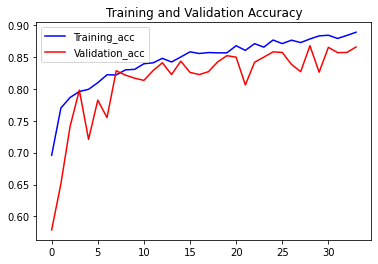

In [22]:
#plot training nad validation accuracy
plt.plot(epochs,acc,label='Training_acc',color='blue')
plt.plot(epochs,val_acc,label='Validation_acc',color='red')
plt.legend()
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation loss')

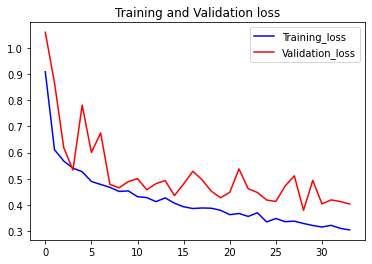

In [23]:
#training and validation loss
plt.plot(epochs,loss,label='Training_loss',color='blue')
plt.plot(epochs,val_loss,label='Validation_loss',color='red')
plt.legend()
plt.title("Training and Validation loss")

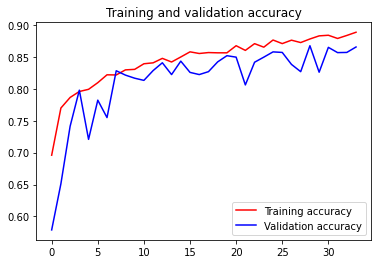

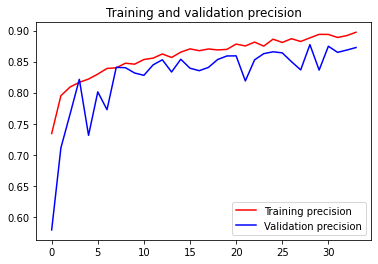

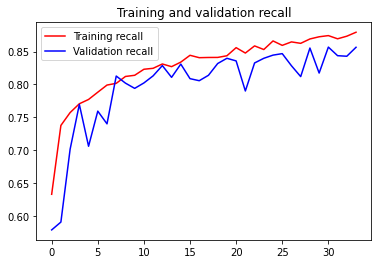

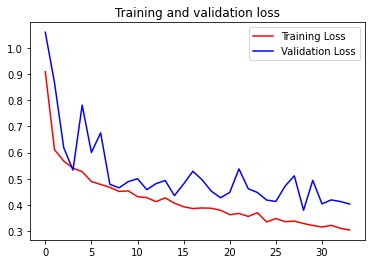

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_precision=history.history['precision']
val_precision=history.history['val_precision']

train_recall=history.history['recall']
val_recall=history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.figure()

plt.plot(epochs, train_recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
#model history
import pandas as pd
loss_df = pd.DataFrame(ResNet50_MODEL.history.history)
loss_df

""


In [26]:
#prediction on test data
predictions = np.argmax(ResNet50_MODEL.predict(test_set), axis = -1)

28/28 [==============================] - 8s 239ms/step


In [27]:
#classification report
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       362
           1       0.73      0.66      0.69       246
           2       0.90      0.88      0.89      1020
           3       0.79      0.92      0.85       135

    accuracy                           0.85      1763
   macro avg       0.81      0.84      0.82      1763
weighted avg       0.85      0.85      0.85      1763



In [28]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(test_set.classes, predictions)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

[[322   8  31   1]
 [ 19 163  64   0]
 [ 41  50 897  32]
 [  4   3   4 124]]
sensitivity: 0.9758
specificity: 0.8956


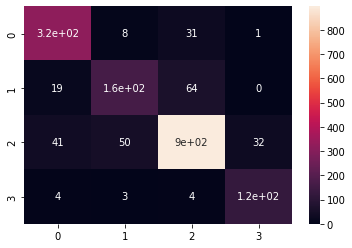

In [29]:
import seaborn as sns
print(confusion_matrix(test_set.classes,predictions))
sns.heatmap(confusion_matrix(test_set.classes,predictions), annot = True)
# show the sensitivity, and specificity
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

In [30]:
from numpy import sqrt

In [31]:
G_Mean = sqrt(sensitivity * specificity)
print("G_Mean: ", G_Mean)

G_Mean:  0.9348223220980412


In [32]:
True_Positive_Rate = cm[0, 0] / (cm[0, 0] + cm[0, 1])
False_Positive_Rate = cm[1, 0] / (cm[1, 0] + cm[1, 1])

In [33]:
print("True_Positive_Rate: {:.4f}".format(True_Positive_Rate))
print("False_Positive_Rate: {:.4f}".format(False_Positive_Rate))

True_Positive_Rate: 0.9758
False_Positive_Rate: 0.1044


# **ROC**

In [34]:
print(test_set)
print(predictions)

[0 0 0 ... 3 3 3]


In [35]:
testsetTo = np.concatenate([test_set.next()[1] for i in range(test_set.__len__())])
print(testsetTo.shape)

(1763, 4)


In [36]:
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [37]:
#ROC-AUC Curve
# Learn to predict each class against the other
n_classes = 4 
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
thresh = dict()
roc_auc = dict()
lw = 2 
for i in range(n_classes):
    fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(testsetTo, axis=1), predictions, pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [38]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thresh[i] = roc_curve(np.argmax(testsetTo, axis=1), predictions, pos_label=i) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # This is added back by InteractiveShellApp.init_path()


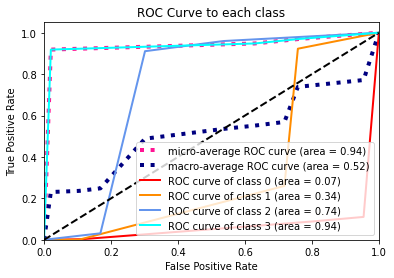

In [39]:
# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle
roc_auc_scores = []
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['red', 'darkorange', 'cornflowerblue', 'aqua'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    roc_auc_scores.append(roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve to each class')
plt.legend(loc="lower right")
plt.show()